In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

import nest

seed = np.random.randint(0,1e9)
nest.SetKernelStatus({'rng_seed':seed})


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Nov  6 2022 20:23:54

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
## Network parameters
N = N_ex = N_in = N_cj = 90  # number of neurons in each ring
ms = 1e-3
T = 60/ms                      # simulation time in ms

mu = 0.5
sigma = 0.12
delay = 0.1

base_ex = 4000
base_in = 450
base_cj_ex = 169
weight_ex_cj = 660

In [3]:
I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = int(N_ex//2)

In [4]:
pop_ex = nest.Create('iaf_psc_alpha', N_ex, params={'I_e': 450.})
pop_in = nest.Create('iaf_psc_alpha', N_in)

turn_left = nest.Create('iaf_psc_alpha', N_cj)
turn_right = nest.Create('iaf_psc_alpha', N_cj)

In [5]:
# connections between excitatory and inhibitory rings
w_ex = np.empty((N_in,N_ex))
w_in = np.empty((N_ex,N_in))

for e in range(N_ex):
    for i in range(N_in):
        d1 = np.abs(e/N_ex - i/N_in)
        d2 = np.abs(e/N_ex - i/N_in - 1)
        d3 = np.abs(e/N_ex - i/N_in + 1)
        
        d = min(d1,d2,d3)
         
        w_ex[i,e] = base_ex * np.exp(-d**2/(2*sigma**2))
        w_in[e,i] = base_in * np.exp(-(d - mu)**2/(2*sigma**2)) 
            
w_ex[w_ex<10]=0
w_in[w_in<10]=0

In [6]:
# connections between conjuntive layers and excitatory ring
w_l = np.empty((N_ex,N_cj))
w_r = np.empty((N_ex,N_cj))

for c in range(N_cj):  
    for e in range(N_ex):
        d1 = np.abs((e-1)/N_ex - c/N_cj)
        d2 = np.abs((e-1)/N_ex - c/N_cj -1)
        d3 = np.abs((e-1)/N_ex - c/N_cj +1)
        
        d = min(d1,d2,d3)
        w_l[e,c] = base_cj_ex * np.exp(-d**2/(2*sigma**2))
        
        d1 = np.abs((e+1)/N_cj - c/N_ex)
        d2 = np.abs((e+1)/N_cj - c/N_ex -1)
        d3 = np.abs((e+1)/N_cj - c/N_ex +1)
        
        d = min(d1,d2,d3)
        w_r[e,c] = base_cj_ex * np.exp(-d**2/(2*sigma**2))
        
m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0

In [7]:
exc_2_inh = nest.Connect(pop_ex, pop_in, conn_spec='all_to_all', syn_spec={'weight': w_ex, 'delay': delay})
inh_2_exc = nest.Connect(pop_in, pop_ex, conn_spec='all_to_all', syn_spec={'weight': -w_in, 'delay': delay})

exc_2_l = nest.Connect(pop_ex, turn_left, conn_spec='one_to_one', syn_spec={'weight': weight_ex_cj, 'delay': delay})
exc_2_r = nest.Connect(pop_ex, turn_right, conn_spec='one_to_one', syn_spec={'weight': weight_ex_cj, 'delay': delay})

l_2_exc = nest.Connect(turn_left, pop_ex, conn_spec='all_to_all', syn_spec={'weight': w_l, 'delay': delay})
r_2_exc = nest.Connect(turn_right, pop_ex, conn_spec='all_to_all', syn_spec={'weight': w_r, 'delay': delay})

In [8]:
noise_ex = nest.Create('poisson_generator', N_cj)
noise_in = nest.Create('poisson_generator', N_cj)
noise_ex.set(rate=80000.0)
noise_in.set(rate=16000.0)

In [9]:
syn_dict_ex = {'weight': 1.2}
syn_dict_in = {'weight': -2.0}
nest.Connect(noise_ex, turn_left, conn_spec='one_to_one', syn_spec=syn_dict_ex)
nest.Connect(noise_in, turn_left, conn_spec='one_to_one', syn_spec=syn_dict_in)
nest.Connect(noise_ex, turn_right, conn_spec='one_to_one', syn_spec=syn_dict_ex)
nest.Connect(noise_in, turn_right, conn_spec='one_to_one', syn_spec=syn_dict_in)

spikerecorder = nest.Create('spike_recorder')
nest.Connect(pop_ex, spikerecorder)

In [10]:
bump_init = nest.Create('step_current_generator', 1, params={'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
nest.Connect(bump_init, pop_ex[I_init_pos])

In [11]:
nest.Simulate(T)


Mar 17 16:18:07 NodeManager::prepare_nodes [Info]: 
    Preparing 542 nodes for simulation.

Mar 17 16:18:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 542
    Simulation time (ms): 60000
    Number of OpenMP threads: 1
    Not using MPI

Mar 17 16:18:29 SimulationManager::run [Info]: 
    Simulation finished.


In [12]:
data = spikerecorder.get('events')
t = data['times']
spikes = data['senders']

In [13]:
fps = 10
rescaled_T = T//fps
time = np.arange(1,rescaled_T)

direction = []
for t_ in time:
    direction.append(scipy.stats.circmean(spikes[(t/fps < t_) & (t/fps > t_-1)], high=N, low=0))

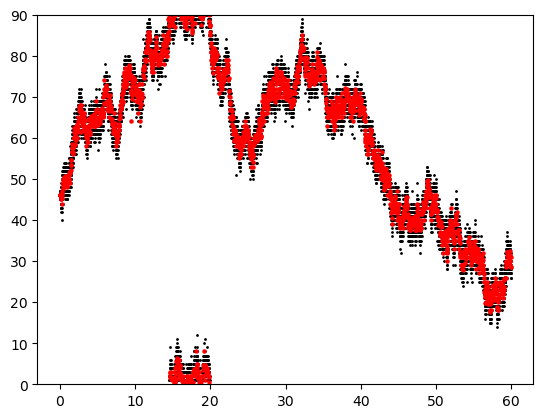

In [14]:
plt.scatter(t/1000., spikes, c='black', s=1)
plt.scatter(time/rescaled_T*T*ms, direction, c='red', s=5)
plt.ylim(0,N)
plt.show()

In [15]:
df = pd.DataFrame(np.array([time, direction]).T, columns=['time', 'theta'])
df['theta'] = df['theta'] / N * 360.

df['dir_x'] = np.cos(df['theta']*np.pi/180.)
df['dir_y'] = np.sin(df['theta']*np.pi/180.)
df['pos_x'] = df['dir_x'].cumsum()
df['pos_y'] = df['dir_y'].cumsum()

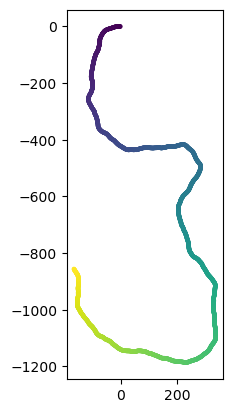

In [16]:
plt.scatter(df['pos_x'], df['pos_y'], c=df['time'], s=5)
ax = plt.gca()
ax.set_aspect('equal')
plt.show()